# Rho $\gamma_4$-current

### Parameter list

In [1]:
# Commonly changed parameters
const hadron = "rho"
const g = 8
const p_src = (-1,0,0)
const p_snk = (0,0,0)
const fit_data = true

# Other parameters
const size_s = 16
const size_t = 60
const m = "-8999"
const q = (p_snk[1]-p_src[1],p_snk[2]-p_src[2],p_snk[3]-p_src[3])
const sources = ["DG0_1", "DG1_1", "DG1_1", "DG2_1", "DG2_1"]
const sinks = ["DG0_1", "DG1_1", "DG1_1", "DG2_1", "DG2_1"]
const file_prefix = "/home/arios/Documents/LQCDConfigs/wil_16_60_aniso_cluster/" * hadron * "/"

if g in [1,2,4,8,7,11,13,14]
    const curr = "nonlocal"
else
    const curr = "local"
end

if hadron == "rho"
    const t_gen_ev = 0
    const t_var = 10
    const t_sn = 10
    const t_sink = 21
    const g_ins = 1
    const had = "rho_x"
    const seqsource = "a0-rho_x_1"
elseif hadron == "nucleon_pol"
    const t_gen_ev = 0
    const t_var = 18
    const t_sn = 18
    const t_sink = 21
    const g_ins = 0
    const had = "NUCL_D_POL"
    const seqsource = "a0-rho_x_1"
elseif hadron == "nucleon_unpol"
    const t_gen_ev = 0
    const t_var = 18
    const t_sn = 18
    const t_sink = 21
    const g_ins = 0
    const had = "rho_x"
    const seqsource = "NUCL_D_UNPOL"
end;

### $\gamma$-matrices cheat sheet

  $\Gamma$ | $n_\Gamma$ | Particle State || $\Gamma$ | $n_\Gamma$ | Particle State
  :---------:|:------------:|:---------:||:--------:|:--------:|:-----------:
  1 | 0 | $a_0$ || $\gamma_4$ | 8 | $a_0$
  $\gamma_1$ | 1 | $\rho(x)$ || $\gamma_1\gamma_4$ | 9 | $\rho(x)$
  $\gamma_2$ | 2 | $\rho(y)$ || $\gamma_2\gamma_4$ | 10 | $\rho(y)$
  $\gamma_1\gamma_2$ | 3 | $b_1(z)$ || $\gamma_3\gamma_5$ | 11 | $a_1(z)$
  $\gamma_3$ | 4 | $\rho(z)$ || $\gamma_3\gamma_4$ | 12 | $\rho(z)$
  $\gamma_1\gamma_3$ | 5 | $-b_1(y)$ || $-\gamma_2\gamma_5$ | 13 | $-a_1(y)$
  $\gamma_2\gamma_3$ | 6 | $b_1(x)$ || $\gamma_1\gamma_5$ | 14 | $a_1(x)$
  $-\gamma_4\gamma_5$ | 7 | $\pi$ || $\gamma_5$ | 15 | $\pi$

The table was taken from [here](https://rqcd.uni-regensburg.de/chroma-tutorial/chroma_gamma_matrices.pdf).

### Load modules and data

In [2]:
push!(LOAD_PATH, pwd())
using lqcd, lqcdfits, PyPlot

const had_3ptfn = read_bar3ptfn_file(seqsource, curr, g_ins, g, q, p_snk, sources, sinks, file_prefix)
const had_2ptfn_src = read_hadspec_file(had, m, p_src, sources, sinks, file_prefix)
const had_2ptfn_snk = read_hadspec_file(had, m, p_snk, sources, sinks, file_prefix);

### Process data

In [3]:
had_mass, had_mass_err, had_ff, had_ff_err = find_mass_and_ff(had_3ptfn, had_2ptfn_src, had_2ptfn_snk, t_sink, t_gen_ev, t_var, t_sn);

Performing bootstrapping...   100%|██████████████████████████████████████████████████| Time: 0:00:18


### Fit data

In [4]:
if fit_data
    limits, mass_sys, mass_sys_err = scan_range_2ptfn(had_2ptfn_snk, t_gen_ev, t_var, t_sn, [4e-7, 0.3], func="cosh")
    mass_stat, mass_stat_err = find_mass_fit(had_2ptfn_snk, t_gen_ev, t_var, t_sn, limits, [4e-7, 0.3], func="cosh")
end;

Scanning fit range...         100%|██████████████████████████████████████████████████| Time: 0:00:02
Performing bootstrapping...   100%|██████████████████████████████████████████████████| Time: 0:01:06


### Mass plots

Here are a few mass plots just to verify that things are working correctly.

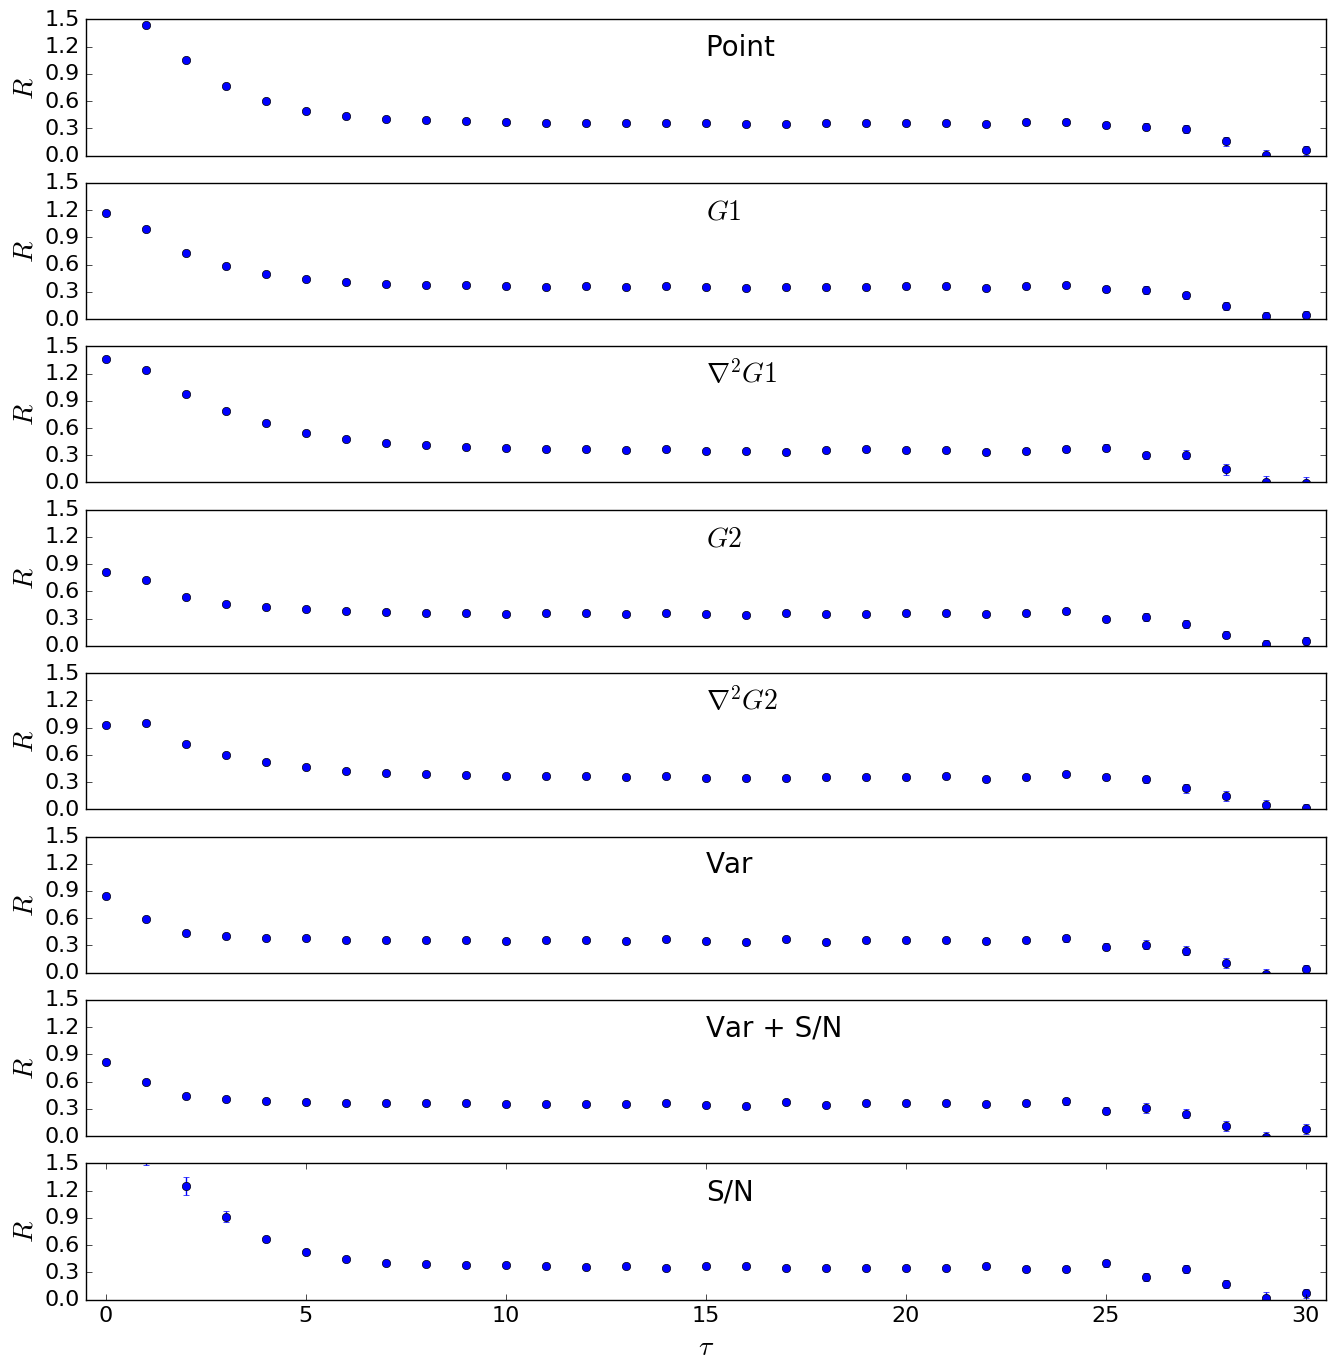

In [5]:
type_labels = ["Point", "\$G1\$", "\$\\nabla^2 G1\$", "\$G2\$", "\$\\nabla^2 G2\$", "Var", "Var + S/N", "S/N"]
figure(1, figsize=(16, 16))
for x in 1:8
    subplot(810+x)
    errorbar(0:(length(had_mass[x,:])-1), had_mass[x,:], yerr=had_mass_err[x,:], color="b", ecolor="b", capsize=2, fmt="o")
    ylabel("\$R\$", fontsize=20)
    text(15., 1.1, type_labels[x], fontsize=20)
    xlim(-0.5, size_t/2+0.5)
    ylim(0., 1.5)
    yticks(0.:0.3:1.5, fontsize=16)
    if x == 8
        xlabel("\$\\tau\$", fontsize=20)
        xticks(0:5:30, fontsize=16)
    else
        xticks([])
    end
end

### Show results from the mass fits (if available)

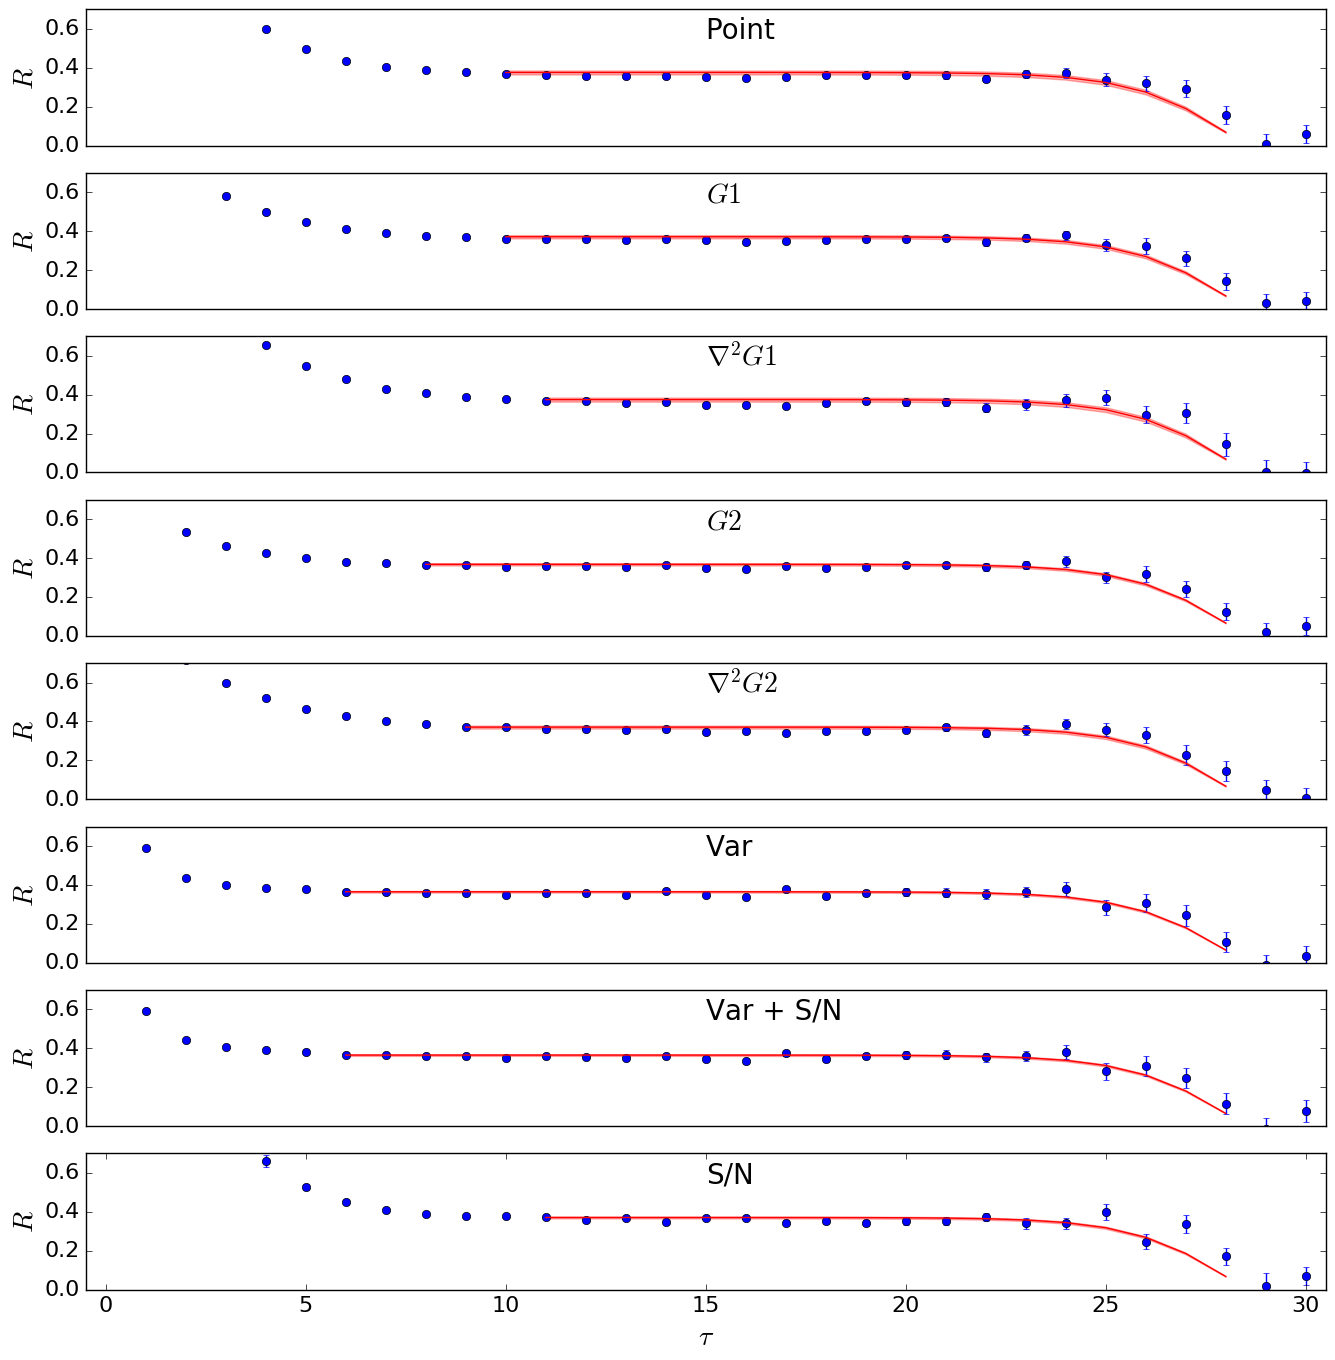

Effective masses extracted from the fit


Point        : 0.3763 +- 0.0089 (stat) +- 0.0013 (sys)
$G1$         : 0.3718 +- 0.0075 (stat) +- 0.0009 (sys)
$\nabla^2 G1$: 0.3746 +- 0.0090 (stat) +- 0.0015 (sys)
$G2$         : 0.3678 +- 0.0053 (stat) +- 0.0005 (sys)
$\nabla^2 G2$: 0.3710 +- 0.0067 (stat) +- 0.0007 (sys)
Var          : 0.3646 +- 0.0038 (stat) +- 0.0005 (sys)
Var + S/N    : 0.3651 +- 0.0039 (stat) +- 0.0005 (sys)
S/N          : 0.3702 +- 0.0036 (stat) +- 0.0013 (sys)


In [6]:
if fit_data
    type_labels = ["Point", "\$G1\$", "\$\\nabla^2 G1\$", "\$G2\$", "\$\\nabla^2 G2\$", "Var", "Var + S/N", "S/N"]
    println("Effective masses extracted from the fit\n\n")
    for x in 1:8
        name = type_labels[x]*" "^(13-length(type_labels[x]))
        @printf "%s: %.4f +- %.4f (stat) +- %.4f (sys)\n" name mass_stat[x] mass_stat_err[x] mass_sys_err[x]
    end
    figure(1, figsize=(16, 16))
    for x in 1:8
        subplot(810+x)
        errorbar(0:(length(had_mass[x,:])-1), had_mass[x,:], yerr=had_mass_err[x,:], color="b", ecolor="b", capsize=2, fmt="o")
        ylabel("\$R\$", fontsize=20)
        text(15., 0.55, type_labels[x], fontsize=20)
        xlim(-0.5, size_t/2+0.5)
        ylim(0., 0.7)
        yticks(0.:0.2:0.6, fontsize=16)
        if x == 8
            xlabel("\$\\tau\$", fontsize=20)
            xticks(0:5:30, fontsize=16)
        else
            xticks([])
        end
        times = [(limits[x,1]:limits[x,2])-1;]
        y = [log(cosh_func(i,size_t,[1.,mass_stat[x]])/cosh_func(i+1,size_t,[1.,mass_stat[x]])) for i in limits[x,1]:limits[x,2]]
        yminuserr = [log(cosh_func(i,size_t,[1.,mass_stat[x]-mass_stat_err[x]-mass_sys_err[x]])/cosh_func(i+1,size_t,[1.,mass_stat[x]-mass_stat_err[x]-mass_sys_err[x]])) for i in limits[x,1]:limits[x,2]]
        ypluserr = [log(cosh_func(i,size_t,[1.,mass_stat[x]+mass_stat_err[x]+mass_sys_err[x]])/cosh_func(i+1,size_t,[1.,mass_stat[x]+mass_stat_err[x]+mass_sys_err[x]])) for i in limits[x,1]:limits[x,2]]
        plot(times, y, color="red")
        fill_between(times, yminuserr, ypluserr, alpha=0.3, color="red")
    end
end

### Charge/form factor plots

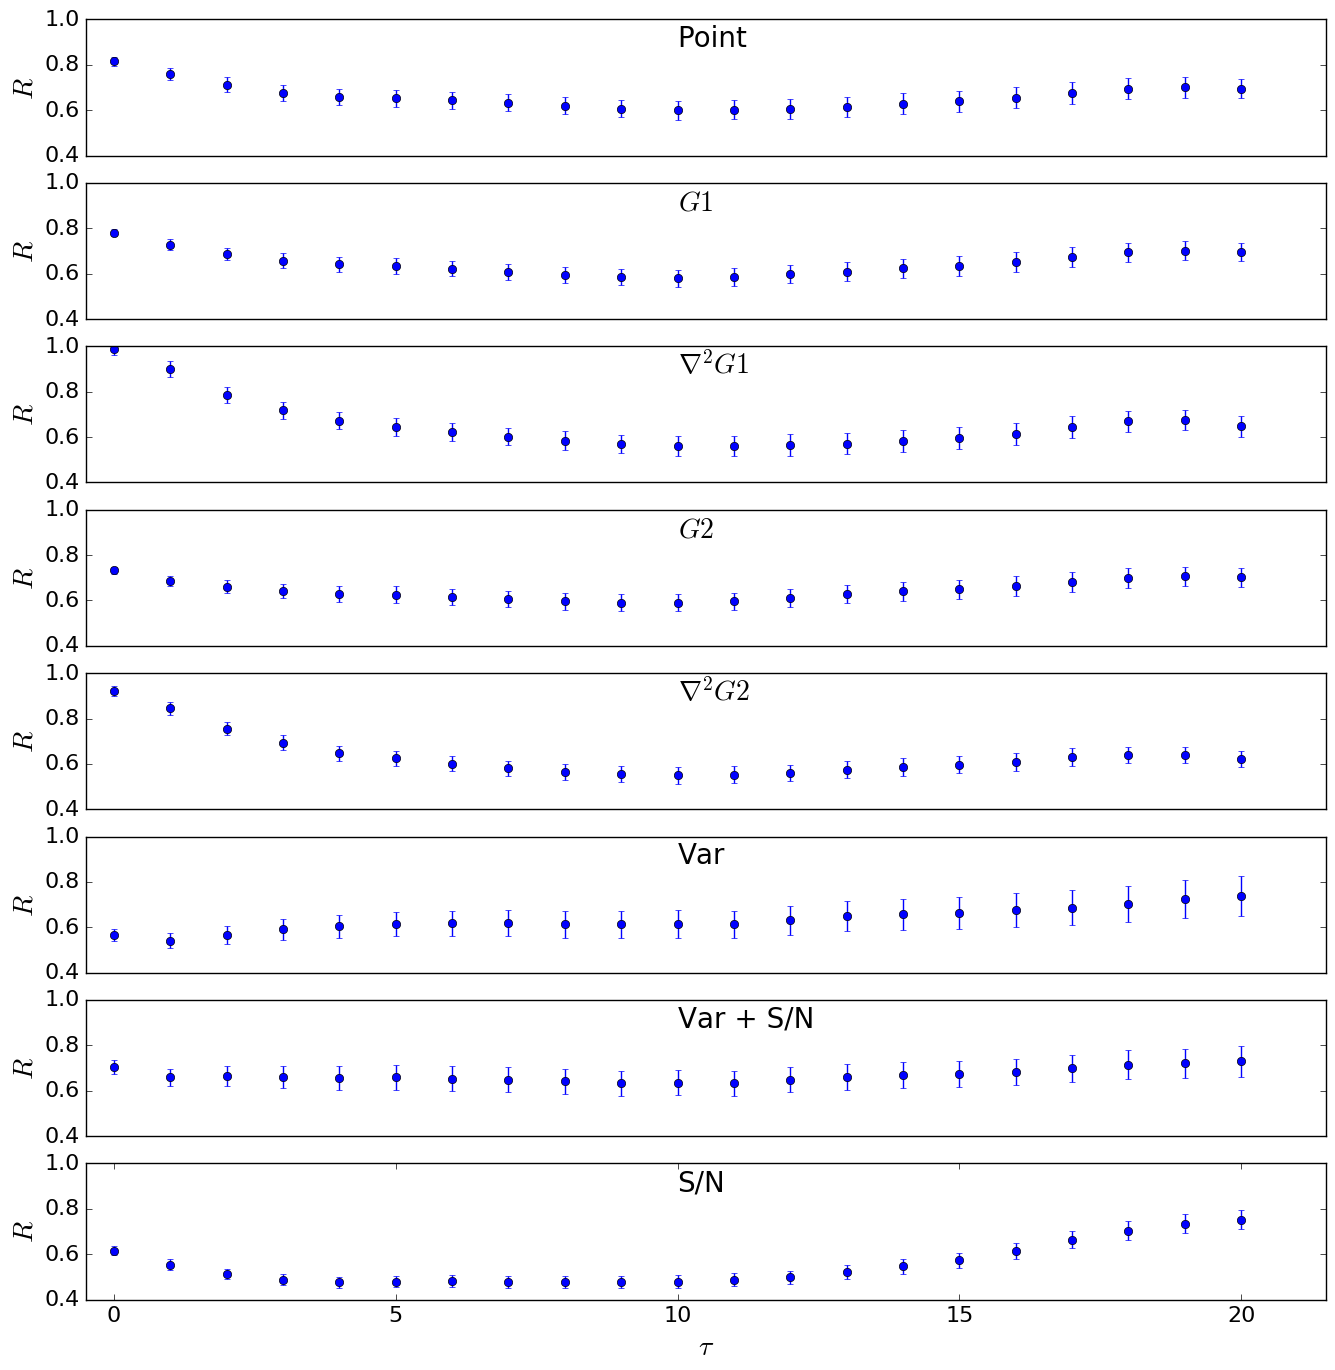

In [7]:
type_labels = ["Point", "\$G1\$", "\$\\nabla^2 G1\$", "\$G2\$", "\$\\nabla^2 G2\$", "Var", "Var + S/N", "S/N"]
figure(1, figsize=(16, 16))
for x in 1:8
    subplot(810+x)
    ax = gca()
    errorbar(0:(length(had_ff[x,:])-1), had_ff[x,:], yerr=had_ff_err[x,:], color="b", ecolor="b", capsize=2, fmt="o")
    ylabel("\$R\$", fontsize=20)
    text(10., 0.88, type_labels[x], fontsize=20)
    xlim(-0.5, t_sink+0.5)
    ylim(0.4, 1)
    yticks(0.4:0.2:1., fontsize=16)
    if x == 8
        xlabel("\$\\tau\$", fontsize=20)
        xticks(0:5:t_sink, fontsize=16)
    else
        xticks([])
    end
end